<a href="https://colab.research.google.com/github/Vseshad/Projects/blob/main/DO_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction
This project is used to design a Model Predictive Controller for a overhead crane system. It involves tuning the controller and using state space model to meet specific parametric objectives.

The crane system can be considered as an inverted pendulum assembly where the force on the counter weight can be used to control the displaceent of cart and using MPC to terminate the displacement at a pirticular point. The controller's goal is to modify the force applied to the cart, guiding the pendulum mass from its initial position at -1 to a new target position of 0. It aims to achieve this by ensuring the pendulum starts and ends with zero velocities and angles, all while adhering to specified input criteria.

Consider a siple formulation where y(t) is the position, v(t) is the velocity, θ(t) is the angle, q(t) is the angular rate and u(t) is the force on the cart.

The control input u(t) includes the velocity v(t) and the position y(t).

The discrete-time dynamics follows:

dy/dt = u(t)

dv/dt = θ(t)*ε + u(t)

dθ/dt = q(t)

dq/dt = -θ(t) - u(t)

The optimization problem is formulated as:

$$
\begin{aligned}
\min_{u} \quad & \quad ||y(t)+v(t)+θ(t)+q(t)||^2 \\
\end{aligned}
$$
The function value is minimized at the destination location.

In [ ]:
# Installing GEKKO package
!pip install gekko

# Sample Code
The first setep is to install GEKKO package and the rest of the sample code is given below.

In [ ]:
# Importing packages
import matplotlib.animation as animation
from gekko import GEKKO
import numpy as np

# Defining a model
model = GEKKO()

# Defining time horizon, 10s to ensure stationarity
model.time = np.linspace(0, 10, 100)

# Defining item and counter weight
m2 = 2
m1 = 10

# Defining Model Parameters
mass1 = model.Param(value=m1)   # Mass of Cart
mass2 = model.Param(value=m2)   # Mass of transported item
t = 8                           # Time by which the object reaches the destination location

final = np.zeros(len(model.time))
for i in range(len(model.time)):
    if model.time[i] < t:
        final[i] = 0
    else:
        final[i] = 1
final = model.Param(value=final)

# Defining the State Variables Initial Conditions

# Un-Controlled Variables
q = model.Var(value=0)          # Angular Rate
theta = model.Var(value=0)      # Angle

# Controlled Variables
v = model.Var(value=0)          # Velocity
y = model.Var(value=-1)         # Position goes from -1 to 0

# Definining the Foce on the cart (Manupulated Variable)
u = model.Var(value=0)          # Force on the cart

# Defining Mass Fraction variable (Used for simplification)
epsilon = model.Intermediate(mass2 / (mass1 + mass2))

# Defining List of Equations
model.Equation(theta.dt() == q)
model.Equation(q.dt() == - u -theta)
model.Equation(v.dt() == theta*epsilon + u)
model.Equation(y.dt() == v)

# Defining Objective Function
model.Obj(final *( y**2 + v**2 + theta**2 + q**2))

# To minimize change of MV
model.Obj(0.0002 * u**2)

# Control
model.options.IMODE = 6

# Solve
model.solve(disp=False)


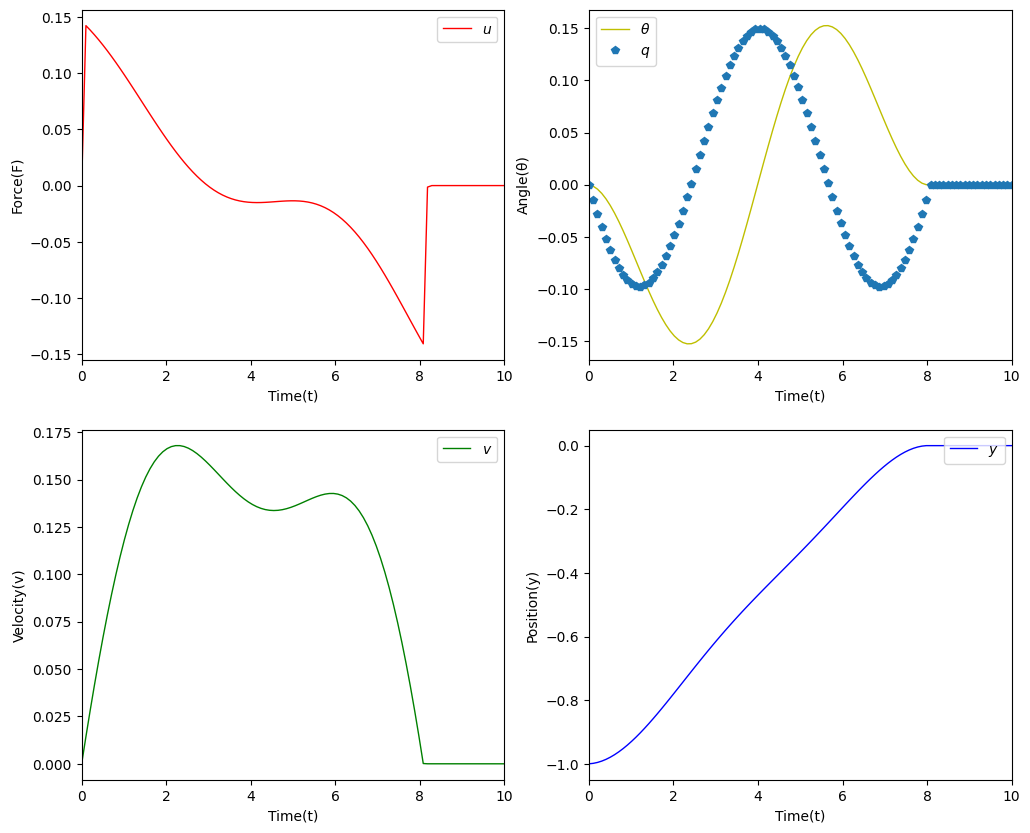

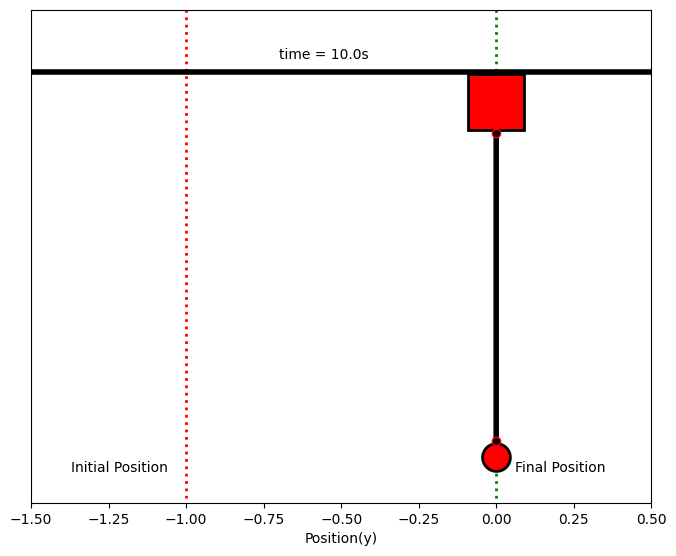

In [ ]:
#Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.plot(model.time,u.value,'r',lw=1)
plt.xlabel('Time(t)')
plt.ylabel('Force(F)')
plt.xlim(model.time[0],model.time[-1])
plt.legend([r'$u$'],loc=1)

plt.subplot(222)
plt.plot(model.time,theta.value,'y',lw=1)
plt.plot(model.time,q.value,'p',lw=1)
plt.xlabel('Time(t)')
plt.ylabel('Angle(θ)')
plt.xlim(model.time[0],model.time[-1])
plt.legend([r'$θ$',r'$q$'],loc=2)

plt.subplot(223)
plt.plot(model.time,v.value,'g',lw=1)
plt.xlabel('Time(t)')
plt.ylabel('Velocity(v)')
plt.xlim(model.time[0],model.time[-1])
plt.legend([r'$v$'],loc=1)

plt.subplot(224)
plt.plot(model.time,y.value,'b',lw=1)
plt.xlabel('Time(t)')
plt.ylabel('Position(y)')
plt.xlim(model.time[0],model.time[-1])
plt.legend([r'$y$'],loc=1)

plt.rcParams['animation.html'] = 'html5'

y1 = np.zeros(len(model.time))
x1 = y.value

# Considering length of space = 1
y2 = -1*np.cos(theta.value)+y1
y_2 = -1.05*np.cos(theta.value)+y1
x2 = 1*np.sin(theta.value)+x1
x_2 = 1.05*np.sin(theta.value)+x1

fig = plt.figure(figsize=(8,6.4))

ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-1.5,0.5),ylim=(-1.2,0.4))
ax.set_xlabel('Position(y)')
ax.get_yaxis().set_visible(False)

start, = ax.plot([-1,-1],[-1.5,1],'r:',lw=2)
finish, = ax.plot([0,0],[-1.5,1],'g:',lw=2)
rail, = ax.plot([-1.5,0.5],[0.2,0.2],color='black',lw=4)
ma_1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='red',markeredgewidth=2)
ma_2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='red',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='black',lw=4,\
                markersize=6,markeredgecolor='r',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.4,0.9,'',transform=ax.transAxes)

start_text = ax.text(-1.06,-1.1,'Initial Position',ha='right')
end_text = ax.text(0.06,-1.1,'Final Position',ha='left')

# Initialization
def init():
    ma_1.set_data([],[])
    ma_2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    return ma_1, ma_2, time_text, line

# Annimation
def animate(i):
    ma_1.set_data([x1[i]],[y1[i]+0.1])
    ma_2.set_data([x_2[i]],[y_2[i]])
    line.set_data([x1[i],x2[i]],[y1[i],y2[i]])
    time_text.set_text(time_template % model.time[i])
    return ma_1, ma_2, time_text, line

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(model.time)), \
         interval=20,blit=False,init_func=init)

# Save
ani_a.save('Crane_Control.mp4',fps=50)

# Display
plt.show()